In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Introduction

Educational institutions wish to learn from their students in order to provide a rewarding and enriching environment in which to learn. While student results on assessments are the prime indicator of student success, an institution may also which to determine how much of "Success" is indicated by student factors aside from academic achievement. Specifically, how can non-academic features of a student indicate success separate from academic achievement. This project aims to use multiple supervised machine learning methods in order to model and predict if a student meets the requirements for success, as defined by academic achievement, from non-academic measures, most notably demographic and socioeconomic features. This analysis can help identify populations which could need additional support and validate an institutions program of study.

The dataset has eight features, 5 categorical and 3 quantitative, of 1000 students. The categorical variables are a non-exhaustive listing of demographic data which are commonly recorded along with various measures of student achievement. Without specifically asking for socioeconomic level, they do give an indiciation of the socioeconomic status of the student. For example, a student who qualifies for free/reduced lunch and has no test preparation course is more likely to be of a lower socioeconomic level maybe than a student who does not qualify for free/reduced lunch and does take a test preparation course. Modeling these variables can give an indication as to the association they have on academic achievement. 

The quantitative features - math score, writing score, reading score - are the measured outcomes of academic acheivement. While not an exhaustive listing of ways to measure academic achievement (growth or improvement over time could also be important), they do provide a measuring stick in order to assess how the categorical features can be used to predict student outcomes. 

The goal of this study is to assess the prediction accuracy of students results from demographic data using three supervised learning models: Logistic Regression, K-Nearest Neighbors (KNN) Classification, and AdaBoost ensemble modeling. Each model will be assessed on its accuracy (ability to make the correct classification) and F1 score (a balance of recall and precision which determine the true positivity and true negativity rate respectively).  These numbers give an idea as to how well the models do at classifying the students correctly.

# Exploratory Data Analysis

The data will need to be read in and analysed before model can begin. This steps allows for initial observations to help guide the data cleaning and feature engineering process allowing for data to be usable and workable in the modeling step.

In [143]:
data = pd.read_csv('StudentsPerformance.csv')

In [144]:
data.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [145]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Initial observations revealed some cleaning and feature engineering was required so the data was able to be modeled.  First, changing the names of columns to remove spaces. Second, two variables - Race/Ethnicity and Parent Education Level - needed to be cleaned so that the entries were workable. The entries were split and processed to allow for ease in modeling. Third, the categrorical responses needed to be engineering into a form which allowed for modeling. Dummy variables were created and the dataset was reconstituted with the variables in this new form. Finally, a success column was added. This will be the output of our model and what we hope to predict. 

It is important to note that this definition of success is arbritary. Any insitution has their own definition and this one worked best within the context of the dataset and scope of the project. It would be important for any institution to clearly define what student success is and looks like in order to have accurate, meaningful data to that effect. It is also important to recognize that success is relative and has an individualized component and should be treated on an individual basis in addition to being measured against institutional benchmarks.



In [146]:
data = data.rename(columns = {'math score':'math_score',
                              'reading score':'reading_score',
                              'writing score':'writing_score',
                             'parental level of education':'parent_ed_level',
                             'test preparation course':'test_prep_course',
                             'race/ethnicity':'race_ethnicity'})

cutoff = data['math_score'].quantile(q=0.5) + data['reading_score'].quantile(q=0.5) + data['writing_score'].quantile(q=0.5)

data['success'] = np.where(data['math_score'] + data['reading_score'] + data['writing_score'] > cutoff, 1, 0)

data2 = data.copy()
data.head()

,gender,race_ethnicity,parent_ed_level,lunch,test_prep_course,math_score,reading_score,writing_score,success
0,female,group B,bachelor's degree,standard,none,72,72,74,1
1,female,group C,some college,standard,completed,69,90,88,1
2,female,group B,master's degree,standard,none,90,95,93,1
3,male,group A,associate's degree,free/reduced,none,47,57,44,0
4,male,group C,some college,standard,none,76,78,75,1


In [147]:
data['race_ethnicity'] = [x.split(' ')[1] for x in data['race_ethnicity']]
data['parent_ed_level'] = [x.split(' ')[0] for x in data['parent_ed_level']]
data['parent_ed_level'] = [x.split("'")[0] for x in data['parent_ed_level']]

gender = pd.get_dummies(data['gender'],drop_first = True)
race = pd.get_dummies(data['race_ethnicity'],drop_first = True)
parent_ed = pd.get_dummies(data['parent_ed_level'],drop_first = True)
lunch = pd.get_dummies(data['lunch'],drop_first = True)
test_prep = pd.get_dummies(data['test_prep_course'],drop_first = True)

data.drop(columns = ['gender','race_ethnicity','parent_ed_level','lunch','test_prep_course'], inplace=True)
df = pd.concat([data,gender,race,parent_ed,lunch,test_prep], axis=1)


Below, the cleaned and engineered dataset is ready for modeling.

In [148]:
df.head()

,math_score,reading_score,writing_score,success,male,B,C,D,E,bachelor,high,master,some,standard,none
0,72,72,74,1,0,1,0,0,0,1,0,0,0,1,1
1,69,90,88,1,0,0,1,0,0,0,0,0,1,1,0
2,90,95,93,1,0,1,0,0,0,0,0,1,0,1,1
3,47,57,44,0,1,0,0,0,0,0,0,0,0,0,1
4,76,78,75,1,1,0,1,0,0,0,0,0,1,1,1


In [149]:
df.corr()['success']

math_score       0.725905
reading_score    0.781049
writing_score    0.769572
success          1.000000
male            -0.120223
B               -0.084732
C               -0.012281
D                0.079705
E                0.111129
bachelor         0.075857
high            -0.129019
master           0.064663
some            -0.027257
standard         0.216464
none            -0.219921
Name: success, dtype: float64

# Modeling

Two versions of this data will be utilized.  The first is the complete dataset, categorical and quantitative features, and the second is a dataset comprised of only the categorical features. The full version will be used as a comparison for the ability of the models to predict based on the categorical features.

Each dataset is divided randomly into training and testing sets at the standard 80%-20% split.  This allows for the majority of the data to be used to train each model and a smaller, but still useful, proportion to be used to test each model by evaluating its accuracy (% of correct predictions) and F1 (a balance of recall, % of all positives predicted positive, and precision, % of all predicted positive which are actually positive.) Accuracy allows for an overall number indicating how well the model predicts what it should.  F1 allows for an understanding of how false positives and false negatives appear within the model's predictions. Becuase both false positives (saying a student is successful when they are not) and false negatives (saying a student is not successful when they are) are both undesirable for this analysis, F1 allows for an interpretation which takes both undesirable outcomes into account.

Finally, a confusion matrix is used to visually compare predicted successes to actual successes. It produces four numbers corresponding to the overlap of prediction and actual succes. The upper left number and the bottom right represent correct predictions of actually unsuccessful (top left) and actually successful (bottom right) students.  The other two numbers are false negatives (bottom left) and false positives (upper right).  While inaccuracy is expected, these two should be minimized in order to choose a model which has the best predictive ability.


In [150]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['success'])
y = df['success']

X_cat = df.drop(columns = ['math_score','reading_score','writing_score','success'])
y_cat = df['success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cat, y_cat, test_size = 0.2)


## Logistic Model

In [233]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report

LR_model = LogisticRegression().fit(X_train, y_train)
LR_preds = LR_model.predict(X_test)

acc = round(accuracy_score(y_test, LR_preds), 2)
f1 = round(f1_score(y_test, LR_preds, pos_label = 1), 2)
print('accuracy:', acc)
print('f1:', f1)

pred_probs = LR_model.predict_proba(X_test)
fpr1, tpr1, th = roc_curve(y_test, pred_probs[:,1])

accuracy: 0.94
f1: 0.95


/Users/bmckiernan/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [245]:
#define the logistic model for the categrical dataset and make predictions from the test data. 
LR_model2 = LogisticRegression().fit(X_train_c, y_train_c)
LR_preds2 = LR_model2.predict(X_test_c)

#Further calculations for model fit analysis.
pred_probs2 = LR_model2.predict_proba(X_test_c)
fpr2, tpr2, th2 = roc_curve(y_test_c, pred_probs2[:,1])
auc = roc_auc_score(y_test_c, pred_probs2[:,1])

In [248]:
#calculating the odds ratio - the multiplicative change in classificiation odds for each predictor
np.exp(LR_model2.coef_)

array([[0.5618467 , 1.60884171, 1.6017286 , 2.75530314, 2.95499651,
        1.12403354, 0.58056511, 1.78720016, 0.79534217, 2.73190901,
        0.34823529]])

<AxesSubplot:>

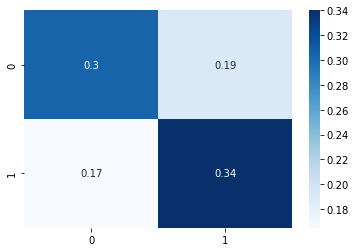

In [267]:
cf = confusion_matrix(y_test_c, LR_preds2, normalize='all')
sns.heatmap(cf, annot=True, cmap='Blues')

In [241]:
target_names = ['success','not success']
print(classification_report(y_test_c, LR_preds2, target_names=target_names))

              precision    recall  f1-score   support

     success       0.65      0.62      0.63        99
 not success       0.64      0.67      0.66       101

    accuracy                           0.65       200
   macro avg       0.65      0.64      0.64       200
weighted avg       0.65      0.65      0.64       200



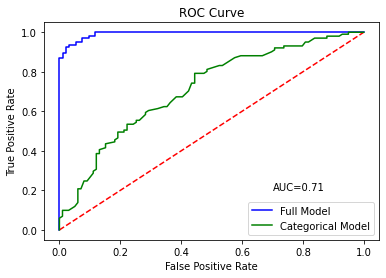

In [246]:
plt.plot(fpr1, tpr1, 'blue', label = 'Full Model')
plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1), 'r--')
plt.plot(fpr2, tpr2, 'green', label = 'Categorical Model')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.text(0.7, 0.2, 'AUC='+'{:.2f}'.format(auc))
plt.show()

## K-Nearest Neighbors Model

In [252]:
from sklearn.neighbors import KNeighborsClassifier

i = []
accs = []
f1s = []

for j in range(1,25):
    i.append(j)

    KNN_Model = KNeighborsClassifier(n_neighbors = j).fit(X_train, y_train)
    preds_KNN = KNN_Model.predict(X_test)
    
    accs.append(accuracy_score(y_test, preds_KNN))
    f1s.append(f1_score(y_test, preds_KNN, pos_label = 1))


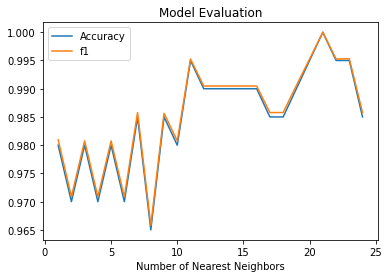

In [253]:
plt.plot(i,accs, label='Accuracy')
plt.plot(i,f1s, label='f1')
plt.xlabel('Number of Nearest Neighbors')
plt.title('Model Evaluation')
plt.legend()
plt.show()

In [232]:
KNN_Model = KNeighborsClassifier(n_neighbors = 21).fit(X_train, y_train)
preds_KNN = KNN_Model.predict(X_test)
acc = round(accuracy_score(y_test, preds_KNN), 2)
f1 = round(f1_score(y_test, preds_KNN, pos_label = 1), 2)
print('accuracy:', acc)
print('f1:', f1)

accuracy: 1.0
f1: 1.0


In [212]:
i_vals = []
acc_vals = []
f1_vals = []

for i in range(1,25):
    i_vals.append(i)
    
    mod = KNeighborsClassifier(n_neighbors = i).fit(X_train_c, y_train_c)
    preds_vals = mod.predict(X_test_c)

    acc_vals.append(accuracy_score(y_test_c, preds_vals))
    f1_vals.append(f1_score(y_test_c, preds_vals, pos_label = 1))


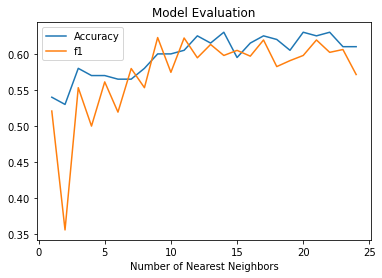

In [213]:
plt.plot(i_vals,acc_vals, label='Accuracy')
plt.plot(i_vals,f1_vals, label='f1')
plt.xlabel('Number of Nearest Neighbors')
plt.title('Model Evaluation')
plt.legend()
plt.show()

In [214]:
KNN_model = KNeighborsClassifier(n_neighbors = 14).fit(X_train_c, y_train_c)
KNN_pred = KNN_model.predict(X_test_c)

print('accuracy:',accuracy_score(y_test_c, KNN_pred))
print('f1:', round(f1_score(y_test_c, KNN_pred, pos_label = 1),2))

accuracy: 0.63
f1: 0.6


<AxesSubplot:>

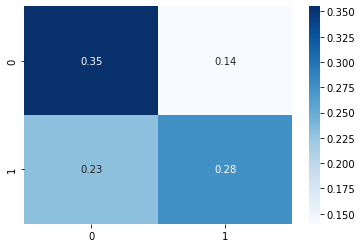

In [268]:
cf2 = confusion_matrix(y_test_c, KNN_pred, normalize='all')
sns.heatmap(cf2, annot=True, cmap='Blues')

## AdaBoost Ensemble Model

In [215]:
from sklearn.ensemble import AdaBoostClassifier

ADA_mod = AdaBoostClassifier().fit(X_train, y_train)
Ada_pred = ADA_mod.predict(X_test)

print('accuracy:', accuracy_score(y_test, Ada_pred))
print('f1:',round(f1_score(y_test, Ada_pred), 2))

accuracy: 0.99
f1: 0.99


In [257]:
vals = []
ada_acc = []
ada_f1 = []

for i in range(1,100):
    vals.append(i)
    
    ADA_mod = AdaBoostClassifier(n_estimators = i).fit(X_train_c, y_train_c)
    Ada_pred = ADA_mod.predict(X_test_c)

    ada_acc.append(accuracy_score(y_test_c, Ada_pred))
    ada_f1.append(f1_score(y_test_c, Ada_pred, pos_label = 1))


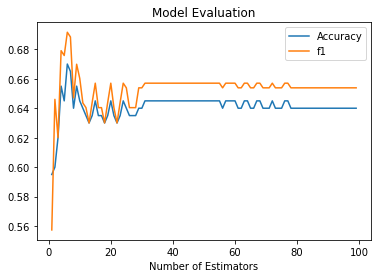

In [258]:
plt.plot(vals,ada_acc, label='Accuracy')
plt.plot(vals,ada_f1, label='f1')
plt.xlabel('Number of Estimators')
plt.title('Model Evaluation')
plt.legend()
plt.show()

In [256]:
ADA_model = AdaBoostClassifier(n_estimators = 7).fit(X_train_c, y_train_c)
ADA_pred = ADA_model.predict(X_test_c)

print('accuracy:', accuracy_score(y_test_c, ADA_pred))
print('f1:', round(f1_score(y_test_c, ADA_pred, pos_label = 1),2))

accuracy: 0.665
f1: 0.69


<AxesSubplot:>

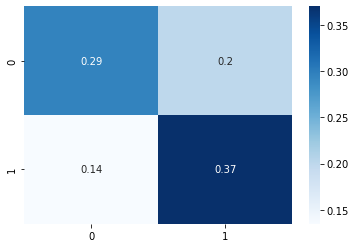

In [269]:
cf3 = confusion_matrix(y_test_c, ADA_pred, normalize='all')
sns.heatmap(cf3, annot= True, cmap='Blues')

# Conclusion and Discussion

The full models all performed in all three modeling scenarios with similar accuracy and f1 as well as the categorical models. There was a noticeable, consistent drop in performance of the cateogorical model underperforming its corresponding full model by roughly 30%.  This consistency is remarkable. It gives an indication to the trouble and folly of trying to assess academic results based on demographic features. It also lends credence to the notion that success should encompass a more well rounded view of achievement rather than a purely academic grounds.

The logistic model provides insight into how the odds of being classified as a "Success" changed based on changes in the categorical features.  Examining the model coefficients and the calculated odds ratios, being in racial groups D and E increase the probability of being successful by 176% and 195% respectively.  Being on standard lunch increases the probability of being successful by about 173%. Unsurprsisingly, identifing or being of a certain racial group has a large impact on academic success as well as if you qualify for free/reduced lunch, a strong measure of socioeconomic status. Considering the confusion matrix, the logistic model was balanced in its ability to recognize true successes and failure with simliar false positive and false negative rates. The AUC of 0.71 indicated that the model is better than random chance (AUC = 0.5) while being far from a perfect classificer (AUC = 1.0).

The K-Nearest Neighbors model classifies instances within the test dataset by comparing it to others nearest to it or most similar. In this case, it considered similarity in regards to many variables and resulted in simliarly accurate predictions as the logistic model when considering the 14 most similar other instances of students. The K-Nearest Neighbors procedure did improve in identifing true negatives, classifying unsuccessful students as unsuccessful, but it also had a much higher false negative rate, more aggressively classifying succesful students as unsuccessful. Conversely, this approach had the lowest rate of false postives mostly due to its inability to correctly recognize successful students.

The AdaBoost model (short for Adaptive Boost) is an ensemble model where successives modeling attempts learn from those misclassified during previous attempts to classify based on the provided predictors. The AdaBoost model did the best at identifying true positives, classifying successful students as successful, but it also has a much higher false positive rate, more aggressively classifying successful students as successful. On the flip side, this approach did have the lowest rate of false negatives, mostly due to its struggles in classifying unsuccessful students correctly.

The general predictive performance was consistent both in how each modeling scenario dealt with the two datasets (categorical and full), the three modeling procedures did have some differences in their effectiveness in what they were able to accurately predict. The high false negative and positive rates in the K-Nearest Neighbors and AdaBoost procedures give pause in their use for this data in a school setting given the impact that a erroneous classification and the resulting implementation could have on student motivation and well-being. The constant accuracy of all three give an indication that each modeling process recognized different aspects on the data and trends which align with so-called successful and unsuccessful students. Their combined, communal use allows for a more well-rounded and nuanced analysis of the data and challenges in this application of prediction.

All three models highlighted a large challenge facing schools: demographics are associated with student performance but just enough to be misleading in admissions and can lead to discrimination. A student's background and family situation have some bearing but cannot be used as strong determinants in anticipating future success. Understanding the role that demographics play is crucial in providing enough support to students who are in danger of being misclassified. A modeling procedure like this can be used to identify those students who would be classified incorrectly, allow for further examination of their record, and provide guidance in proactively offering services to assist those students in order to achieve at their highest potential.
 